# Compare rain event detection methods with the openMRG dataset
In this notebook 4 methods for rain event detection are compared. As CML dataset the opnMRG dataset is used [(Andersson et al. 2022)](https://doi.org/10.5194/essd-14-5411-2022).
The rain event detection methods are from following publications and named after the first author:
* [Schleiss et al. 2010](10.1109/LGRS.2010.2043052)
* [Graf et al. 2020](https://doi.org/10.5194/hess-24-2931-2020)
* [Polz et al. 2020](https://doi.org/10.5194/amt-13-3835-2020)
* [Overeem et al. 2016](https://doi.org/10.5194/amt-9-2425-2016) 

In [141]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import opensense_data_downloader_and_transformer as oddt
import pandas as pd
import pycomlink as pycml
import pycomlink.processing.wet_dry.cnn as cnn
import xarray as xr
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# function from OpenSense sandbox https://github.com/OpenSenseAction/OPENSENSE_sandbox/blob/main/notebooks/Explore_existing_datasets.ipynb
oddt.download_andersson_2022_OpenMRG(
    local_path="data/andersson_2022_OpenMRG/", print_output=True
)

File already exists at desired location data/andersson_2022_OpenMRG/OpenMRG.zip
Not downloading!


In [52]:
# function from sandbox
ds_cml = oddt.transform_andersson_2022_OpenMRG(
    fn="data/andersson_2022_OpenMRG/OpenMRG.zip",
    path_to_extract_to="data/andersson_2022_OpenMRG/",
    time_start_end=(
        "2015-06-01",
        None,
    ),  # default (None, None) -> no timeslicing. ie. ('2015-08-31T00', None),
    restructure_data=True,
)

/bg/home/graf-m/notebooks/cml_method_comparison/waa_comparison/opensense_data_downloader_and_transformer.py:303: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'sublink' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds_multindex = ds.assign_coords({'sublink':df_metadata.index})


### merge city and smhi gauges with 15 min aggregation for wet-dry classification 

In [53]:
df_gauges_city = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/city/CityGauges-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)

df_gauges_city_metadata = pd.read_csv(
    "/pd/home/graf-m/notebooks/cml_method_comparison/gauges/city/CityGauges-metadata.csv",
    index_col=0,
)

In [54]:
ds_gauges_city_org = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["station_id", "time"], df_gauges_city.T),
    ),
    coords=dict(
        station_id=df_gauges_city_metadata.index.values,
        time=df_gauges_city.index.values,
        lon=(["station_id"], df_gauges_city_metadata.Longitude_DecDeg),
        lat=(["station_id"], df_gauges_city_metadata.Latitude_DecDeg),
        location=(["station_id"], df_gauges_city_metadata.Location),
        type=(["station_id"], df_gauges_city_metadata.Type),
        quantization=(["station_id"], df_gauges_city_metadata["Resolution (mm)"]),
    ),
)
ds_gauges_city = ds_gauges_city_org.resample(time="15min", label="right").sum()

In [55]:
df_gauge_smhi = pd.read_csv(
    "/pd/home/graf-m/notebooks/cml_method_comparison/gauges/smhi/GbgA-71420-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)


ds_gauges_smhi = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["station_id", "time"], [df_gauge_smhi.Pvol_mm.values]),
    ),
    coords=dict(
        station_id=["SMHI"],
        time=df_gauge_smhi.index.values,
        lon=(["station_id"], [11.9924]),
        lat=(["station_id"], [57.7156]),
        location=(["station_id"], ["Goeteburg A"]),
        type=(["station_id"], ["15 min rainfall sum"]),
        quantization=(["station_id"], [0.1]),
    ),
)

In [56]:
ds_gauges = xr.concat([ds_gauges_city, ds_gauges_smhi], dim="station_id")
ds_gauges = ds_gauges.sel(time=slice(ds_cml.time.min(),ds_cml.time.max()))


#### calculate distance between city rain gauges and CML center points

In [57]:
ds_cml["lon_center"] = (ds_cml.site_0_lon + ds_cml.site_1_lon) / 2
ds_cml["lat_center"] = (ds_cml.site_0_lat + ds_cml.site_1_lat) / 2

In [58]:
dist_cml_gauges = pycml.spatial.helper.haversine(
    ds_cml.lon_center, ds_cml.lat_center, ds_gauges.lon, ds_gauges.lat
)

In [59]:
# select CMLs closer than a certain distance for later evaluation
close_cmls = dist_cml_gauges.where(dist_cml_gauges < 2, drop=True).cml_id

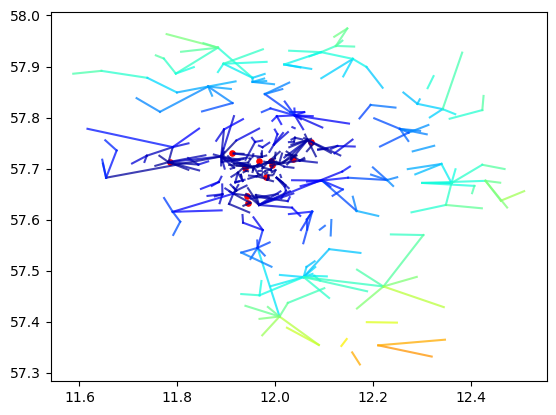

In [60]:
dist_color = plt.cm.jet(np.linspace(0, 1, 500))

cmls_plot = ds_cml
for lon1, lat1, lon2, lat2, dist_to_gauge in zip(
    cmls_plot.site_0_lon,
    cmls_plot.site_0_lat,
    cmls_plot.site_1_lon,
    cmls_plot.site_1_lat,
    dist_cml_gauges.min(dim="station_id").round(1).values * 10,
):
    plt.plot(
        [lon1, lon2], [lat1, lat2], "-", c=dist_color[int(dist_to_gauge)], alpha=0.75
    )

plt.scatter(ds_gauges.lon, ds_gauges.lat, color="red", s=14)

#### Each CML gets the wet-dry time series of the nearest rain gauge as reference

Using the 1 min city gauge data results in too many individual rain events. I tried different paddings and the 15 minute aggregation looked good in several time series. This means that the SMHI rain gauge can be used analog.  

In [61]:
gauges10s = ds_gauges.interp_like(
    ds_cml.time,
)

In [62]:
# resampling 15 gauge data to 10s gauge data
# this pads the original 1 min data by potentielly up to 15 minutes..
gauges10s = ds_gauges.interp_like(ds_cml.time)

# filling wet with the wet-dry time series from the nearest rain gauge
ds_cml["rain_gauge_value"] = xr.full_like(ds_cml.rsl, fill_value=np.nan)
for cmlid in tqdm(ds_cml.cml_id):
    g_id = dist_cml_gauges.argmin(dim="station_id").sel(cml_id=cmlid)

    tmp_ga_rain = (
        np.repeat(
            gauges10s.isel(station_id=g_id).rainfall_amount.values[:, np.newaxis],
            2,
            axis=1,
        )
    )

    ds_cml["rain_gauge_value"].loc[dict(cml_id=cmlid)] = tmp_ga_rain

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:07<00:00, 46.11it/s]


#### Rain event detection methods on one CML to showcase the different methods used here with parameters set to published values


In [63]:
# on 10 second basis for time series based approaches and one single cml
cml = ds_cml.sel(cml_id=10002,time=slice("2015-08-25","2015-09-01"))
gauge = ds_gauges.isel(
    station_id=dist_cml_gauges.sel(cml_id=10002).argmin()
).rainfall_amount

cml["tsl"] = cml.tsl.where((cml.tsl > -10) & (cml.tsl < 40))
cml["rsl"] = cml.rsl.where((cml.rsl > -95) & (cml.rsl < 0))

cml["tl"] = cml.tsl - cml.rsl
cml["tl"] = cml.tl.interpolate_na(dim="time", max_gap="5min", method="linear")

# Schleiss
roll_std_dev = cml.tl.rolling(time=360, center=True).std() 
cml["wet_schleiss"] = roll_std_dev>0.8

# Graf
roll_std_dev = cml.tl.rolling(time=360, center=True).std() 
threshold = 1.12*np.nanquantile(roll_std_dev.values,q=0.8)
cml["wet_graf"] = roll_std_dev>threshold

# Polz
wet_polz_probabilistic = cnn.cnn_wet_dry(
    trsl_channel_1=cml.sel(sublink_id="sublink_1").tl,
    trsl_channel_2=cml.sel(sublink_id="sublink_2").tl,
    batch_size=100)
cml["wet_polz"] = xr.full_like(cml.tl, np.nan)
cml["wet_polz"].loc[dict(sublink_id="sublink_1")] = wet_polz_probabilistic > 0.82
cml["wet_polz"].loc[dict(sublink_id="sublink_2")] = wet_polz_probabilistic > 0.82

# Overeem
# 15 minute basis using several CMLs for the nearby approach
# as this method needs sourounding CMLS, the rain event detection
# is done here already for all CMLs
cmls = ds_cml.sel(time=slice("2015-08-25","2015-09-01"))
cmls['length'][:]=cmls.length/1000
rstl = cmls.rsl - cmls.tsl
pmin = rstl.resample(time="15min").min()
pmax = rstl.resample(time="15min").max()

ds_dist = pycml.processing.wet_dry.nearby_wetdry.calc_distance_between_cml_endpoints(
    cml_ids=cmls.cml_id.values,
    site_a_latitude=cmls.site_0_lat,
    site_a_longitude=cmls.site_0_lon,
    site_b_latitude=cmls.site_1_lat,
    site_b_longitude=cmls.site_1_lon,
)
r = 15  # radius in km
ds_dist["within_r"] = (
    (ds_dist.a_to_all_a < r)
    & (ds_dist.a_to_all_b < r)
    & (ds_dist.b_to_all_a < r)
    & (ds_dist.b_to_all_b < r)
)

wet_overeem, F = pycml.processing.wet_dry.nearby_wetdry.nearby_wetdry(
    pmin=pmin,
    ds_dist=ds_dist,
    radius=15,
    thresh_median_P=-1.4,
    thresh_median_PL=-0.7,
    min_links=3,
    interval=15,
    timeperiod=24,
)

364it [00:00, 392.66it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:09<00:00, 37.25it/s]


#### Plotting TL from a the single CML and the rain event calssification from the different methods.

In [64]:
cml=cml.isel(sublink_id=0)

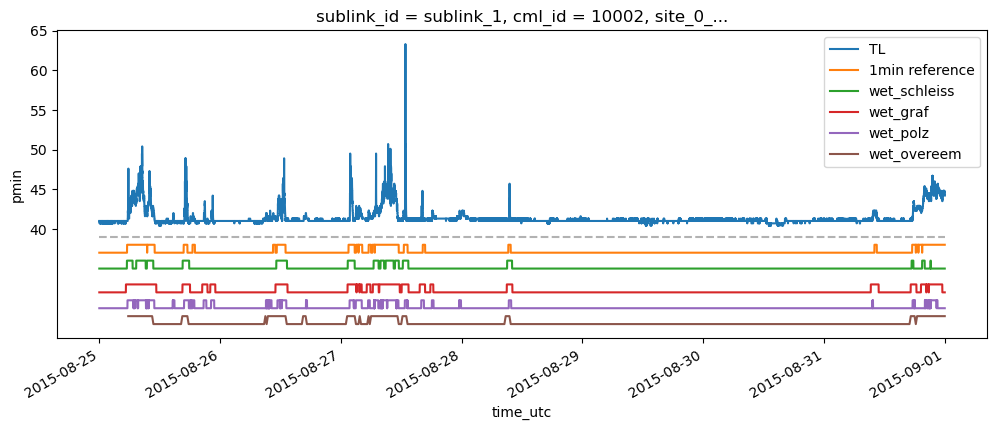

In [65]:
cml.tl.plot(figsize=(12,4),label='TL')
#pmin.sel(cml_id=10002,sublink_id="sublink_1").plot()
((cml.rain_gauge_value>0.01)+37).plot(label="1min reference")
(cml.wet_schleiss+35).plot(label="wet_schleiss")
(cml.wet_graf+32).plot(label="wet_graf")
(cml.wet_polz+30).plot(label="wet_polz")
(wet_overeem.sel(cml_id=10002,sublink_id="sublink_1")+28).plot(label="wet_overeem")
plt.hlines(39,cml.time.min(),cml.time.max(),linestyles='--',color='grey',alpha=0.6)
plt.yticks([40,45,50,55,60,65])
plt.legend();

#### 

#### Process all methods with published parameters and range of thresholds for ROC curves

In [66]:
ds_cml['rain_gauge_wet'] = ds_cml.rain_gauge_value>=0.1
rain_gauge_wet_15min = ds_cml.rain_gauge_wet.resample(time = '15min').max()

In [67]:
ds_radar_along_org = xr.open_dataset("data/andersson_2022_OpenMRG/radar/radar_along_cml.nc")
ds_radar_along_org = ds_radar_along_org.sel(time=slice("2015-06-01",None))
ds_radar_along = ds_radar_along_org.resample(time='15min').max()>0.01


In [69]:
rain_gauge_wet_15min=rain_gauge_wet_15min.to_dataset()
rain_gauge_wet_15min['radar_along_cml'] = xr.full_like(rain_gauge_wet_15min.rain_gauge_wet,fill_value=np.nan)
rain_gauge_wet_15min['radar_along_cml'].loc[dict(sublink_id='sublink_1')]=ds_radar_along.rainfall_amount.sel(time=rain_gauge_wet_15min.time).T
rain_gauge_wet_15min['radar_along_cml'].loc[dict(sublink_id='sublink_2')]=ds_radar_along.rainfall_amount.sel(time=rain_gauge_wet_15min.time).T

In [70]:
%%time
cml = ds_cml

cml["tsl"] = cml.tsl.where((cml.tsl > -10) & (cml.tsl < 40))
cml["rsl"] = cml.rsl.where((cml.rsl > -95) & (cml.rsl < 0))

cml["tl"] = cml.tsl - cml.rsl
cml["tl"] = cml.tl.interpolate_na(dim="time", max_gap="5min", method="linear")

CPU times: user 32.6 s, sys: 5.54 s, total: 38.1 s
Wall time: 38.3 s


In [71]:
%%time
# Schleiss
roll_std_dev = cml.tl.rolling(time=360, center=True).std() 
cml["wet_schleiss"] = roll_std_dev>0.8

CPU times: user 4.39 s, sys: 403 ms, total: 4.79 s
Wall time: 4.82 s


In [72]:
# loop thorugh thresholds to get ROC curve
# comparison done on 15 min basis
fp_schleiss,fn_schleiss,tp_schleiss,tn_schleiss=[],[],[],[]
for threshold in tqdm(np.linspace(0.1,1.5,49)):
    wet_15_min = (roll_std_dev>threshold).resample(time='15min').max()
    tn, fp, fn, tp = confusion_matrix(
        y_true=rain_gauge_wet_15min.radar_along_cml.values.flatten(),
        y_pred=wet_15_min.values.flatten(),
        normalize='true').ravel()
    tn_schleiss.append(tn)
    fp_schleiss.append(fp)
    fn_schleiss.append(fn)
    tp_schleiss.append(tp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:19<00:00,  1.62s/it]


In [73]:
%%time
# Graf
roll_std_dev = cml.tl.rolling(time=360, center=True).std() 

threshold = 1.12*roll_std_dev.quantile(0.8,dim='time')
cml["wet_graf"] = roll_std_dev>threshold

/bg/fast/env_graf-m/mamba/envs/pycomlink-dev/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


CPU times: user 15 s, sys: 396 ms, total: 15.4 s
Wall time: 15.4 s


In [74]:
import warnings
# offing all nan slice from warning which I cannot supress individually right now...
warnings.filterwarnings('ignore')
# loop through different scaling factors to get ROC curve values
fp_graf,fn_graf,tp_graf,tn_graf=[],[],[],[]
for scaling_factor in tqdm(np.linspace(0.5,2.5,49)):
    threshold=scaling_factor*roll_std_dev.quantile(0.8,dim='time',skipna=True)
    wet_15_min = (roll_std_dev>threshold).resample(time='15min').max()
    tn, fp, fn, tp = confusion_matrix(
        y_true=rain_gauge_wet_15min.radar_along_cml.values.flatten(),
        y_pred=wet_15_min.values.flatten(),
        normalize='true').ravel()
    tn_graf.append(tn)
    fp_graf.append(fp)
    fn_graf.append(fn)
    tp_graf.append(tp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [10:01<00:00, 12.27s/it]


In [37]:
%%time
# not run this time 
# takes quite some time. intermediate result save and loaded herafter
# Polz
cml["wet_polz"] = xr.full_like(cml.tl, np.nan)
for cmlid in tqdm(cml.cml_id):
    cml_tmp = cml.sel(cml_id=cmlid).tl
    cml_tmp=cml_tmp.resample(time="1min").first()
    wet_polz_probabilistic = cnn.cnn_wet_dry(
        trsl_channel_1=cml_tmp.sel(sublink_id="sublink_1"),
        trsl_channel_2=cml_tmp.sel(sublink_id="sublink_2"),
        batch_size=100)
    cml_tmp=cml_tmp.to_dataset()
    cml_tmp['wet_tmp'] = xr.full_like(cml_tmp.tl, np.nan)
    cml_tmp['wet_tmp'].loc[dict(sublink_id="sublink_1")] = wet_polz_probabilistic
    cml_tmp['wet_tmp'].loc[dict(sublink_id="sublink_2")] = wet_polz_probabilistic
    cml["wet_polz"].loc[dict(cml_id=cmlid)]=cml_tmp.wet_tmp.resample(time='10s').ffill()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [1:42:21<00:00, 16.87s/it]

CPU times: user 9h 3min 25s, sys: 48min 54s, total: 9h 52min 20s
Wall time: 1h 42min 22s


In [75]:
# saved result from cell above
cml_wet_polz_probabilistic = xr.open_dataset("/bg/data/2delete_py_envs/env_graf-m/2delete/openMRG_wet_pol_probabilistic_10s.nc")

In [76]:
fp_polz,fn_polz,tp_polz,tn_polz=[],[],[],[]
for threshold in tqdm(np.linspace(0,1,49)):
    wet_15_min = (cml_wet_polz_probabilistic.wet_polz_probabilistic.sel(
            time=slice(cml.time.min(),cml.time.max()))>threshold).resample(time='15min').max()
    tn, fp, fn, tp = confusion_matrix(
        y_true=rain_gauge_wet_15min.radar_along_cml.values.flatten(),
        y_pred=wet_15_min.values.flatten(),
        normalize='true').ravel()
    tn_polz.append(tn)
    fp_polz.append(fp)
    fn_polz.append(fn)
    tp_polz.append(tp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [02:19<00:00,  2.85s/it]


In [79]:
%%time
# Overeeem
ds_cml['length'][:]=ds_cml.length/1000
rstl = ds_cml.rsl - ds_cml.tsl
pmin = rstl.resample(time="15min").min()
pmax = rstl.resample(time="15min").max()

ds_dist = nearby_wetdry.calc_distance_between_cml_endpoints(
    cml_ids=cmls.cml_id.values,
    site_a_latitude=cmls.site_0_lat,
    site_a_longitude=cmls.site_0_lon,
    site_b_latitude=cmls.site_1_lat,
    site_b_longitude=cmls.site_1_lon,
)
r = 15  # radius in km
ds_dist["within_r"] = (
    (ds_dist.a_to_all_a < r)
    & (ds_dist.a_to_all_b < r)
    & (ds_dist.b_to_all_a < r)
    & (ds_dist.b_to_all_b < r)
)
wet_overeem, F = nearby_wetdry.nearby_wetdry(
    pmin=pmin,
    ds_dist=ds_dist,
    radius=15,
    thresh_median_P=-1.4,
    thresh_median_PL=-0.7,
    min_links=3,
    interval=15,
    timeperiod=24,
)

364it [00:00, 400.84it/s]


CPU times: user 48.3 s, sys: 833 ms, total: 49.2 s
Wall time: 49.3 s


In [82]:
# this methods need a 15 min reference
fp_overeem,fn_overeem,tp_overeem,tn_overeem=[],[],[],[]
for threshold_P,threshold_PL in tqdm(zip(
    np.array([np.linspace(-5,-1,25),np.linspace(-1,-0,25)]).flatten(),
    np.array([np.linspace(-2,-0.5,25),np.linspace(-0.5,-0,25)]).flatten())):
    
    wet_overeem_tmp, F_tmp = nearby_wetdry.nearby_wetdry(
        pmin=pmin,
        ds_dist=ds_dist,
        radius=15,
        thresh_median_P=threshold_P,
        thresh_median_PL=threshold_PL,
        min_links=3,
        interval=15,
        timeperiod=24,
    )
    
    tn, fp, fn, tp = confusion_matrix(
        y_true=rain_gauge_wet_15min.radar_along_cml.values.flatten(),
        y_pred=(wet_overeem_tmp>0).values.flatten(),
        normalize='true').ravel()
    
    tn_overeem.append(tn)
    fp_overeem.append(fp)
    fn_overeem.append(fn)
    tp_overeem.append(tp)

50it [36:32, 43.85s/it]


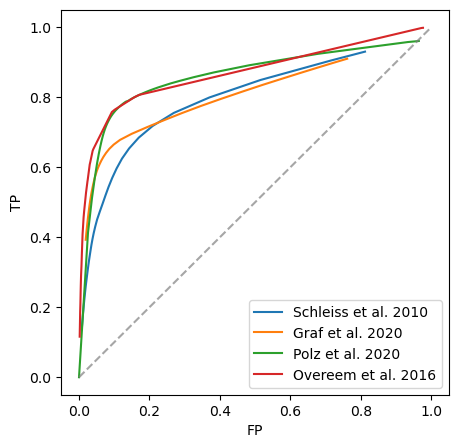

In [85]:
fig,ax = plt.subplots(figsize=(5,5))
plt.plot(fp_schleiss,tp_schleiss,label="Schleiss et al. 2010")
plt.plot(fp_graf,tp_graf,label="Graf et al. 2020")
plt.plot(fp_polz,tp_polz,label="Polz et al. 2020")
plt.plot(fp_overeem,tp_overeem,label="Overeem et al. 2016",color='C3')
plt.plot([0,1],[0,1],'--',color='grey',alpha=0.7)
plt.legend()
plt.ylabel("TP")
plt.xlabel("FP");

#### Evaluate wet-dry against nearest gauge on 15 min basis


In [97]:
cml["wet_polz"]=cml_wet_polz_probabilistic.sel(time=slice("2015-06-01",None)).wet_polz_probabilistic>0.82

In [98]:
%%time
cml_15min = cml.resample(time="15min").max()

CPU times: user 1min 27s, sys: 502 ms, total: 1min 28s
Wall time: 1min 28s


In [99]:
cml_15min["wet_overeem"] = wet_overeem>0

In [132]:
mcc_list,false_wet_list,missed_wet_list,mde_list=[],[],[],[]
for wet_method in ["wet_schleiss","wet_graf","wet_polz","wet_overeem","radar_wet"]:
    tmp_mcc_list,tmp_false_wet_list,tmp_missed_wet_list,tmp_mde_list=[],[],[],[]
    for cmlid in tqdm(cml.cml_id):
        tmp_stats = wet_dry_stats(
            cml_15min.rain_gauge_wet.sel(cml_id=cmlid).values,
            cml_15min[wet_method].sel(cml_id=cmlid).values)
        tmp_mcc_list.append(tmp_stats.matthews_correlation)
        tmp_false_wet_list.append(tmp_stats.false_wet_rate)
        tmp_missed_wet_list.append(tmp_stats.missed_wet_rate)
        tmp_mde_list.append((tmp_stats.false_wet_rate+tmp_stats.missed_wet_rate)/2)
    mcc_list.append(np.array(tmp_mcc_list))
    false_wet_list.append(np.array(tmp_false_wet_list))
    missed_wet_list.append(np.array(tmp_missed_wet_list))
    mde_list.append(np.array(tmp_mde_list))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:00<00:00, 579.89it/s]


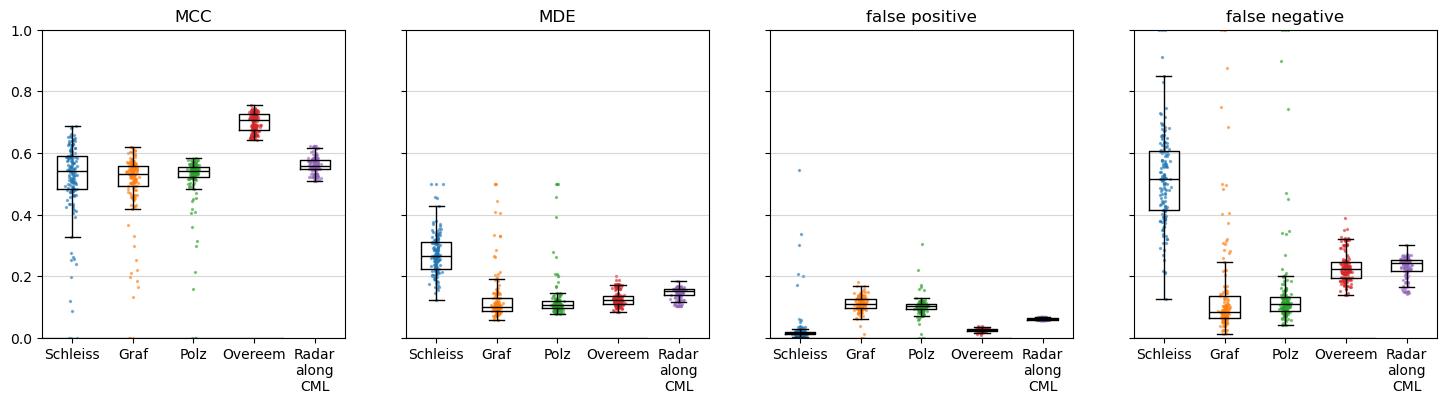

In [140]:
fig, ax = plt.subplots(1,4,figsize=(18,4),sharey=True)
sel_ids = dist_cml_gauges.min(dim='station_id')<3
for metric_list,metric,i in zip([mcc_list,mde_list,false_wet_list,missed_wet_list],['MCC','MDE','false positive','false negative'],range(4)):
    plt.sca(ax[i])
    plot_list=[]
    for i in range(5):
        x=np.random.normal(i+1, 0.04, size=len(metric_list[i][sel_ids]))
        plt.scatter(x,metric_list[i][sel_ids],s=2,alpha=0.5)
        plot_list.append(metric_list[i][sel_ids])
    plt.boxplot(plot_list,sym="", medianprops=dict(color='black') )
    plt.hlines(0,0.5,4.5,color='grey',alpha=0.25)
    plt.xticks([1,2,3,4,5],['Schleiss','Graf','Polz','Overeem','Radar\nalong\nCML'])
    plt.ylim(0,1)
    plt.title(metric)
    plt.grid(axis='y',alpha=0.5)

#### Evaluate against radar along CML paths

In [105]:
ds_radar_along = xr.open_dataset("data/andersson_2022_OpenMRG/radar/radar_along_cml.nc")

In [106]:
ds_radar_along_15min = ds_radar_along.resample(time='15min').sum()

In [107]:
cml_15min['radar_rain'] = xr.full_like(cml_15min.tsl, np.nan)

In [108]:
cml_15min['radar_rain'].loc[dict(sublink_id='sublink_1',time=ds_radar_along_15min.time)] = ds_radar_along_15min.rainfall_amount
cml_15min['radar_rain'].loc[dict(sublink_id='sublink_2',time=ds_radar_along_15min.time)] = ds_radar_along_15min.rainfall_amount

In [109]:
cml_15min['radar_wet'] = cml_15min.radar_rain>0.1

In [110]:
mcc_list,false_wet_list,missed_wet_list,mde_list=[],[],[],[]
for wet_method in ["wet_schleiss","wet_graf","wet_polz","wet_overeem"]:
    tmp_mcc_list,tmp_false_wet_list,tmp_missed_wet_list,tmp_mde_list=[],[],[],[]
    for cmlid in tqdm(cml.cml_id):
        tmp_stats = wet_dry_stats(
            cml_15min.radar_wet.sel(cml_id=cmlid).values,
            cml_15min[wet_method].sel(cml_id=cmlid).values)
        tmp_mcc_list.append(tmp_stats.matthews_correlation)
        tmp_false_wet_list.append(tmp_stats.false_wet_rate)
        tmp_missed_wet_list.append(tmp_stats.missed_wet_rate)
        tmp_mde_list.append((tmp_stats.false_wet_rate+tmp_stats.missed_wet_rate)/2)
    mcc_list.append(np.array(tmp_mcc_list))
    false_wet_list.append(np.array(tmp_false_wet_list))
    missed_wet_list.append(np.array(tmp_missed_wet_list))
    mde_list.append(np.array(tmp_mde_list))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:00<00:00, 595.71it/s]


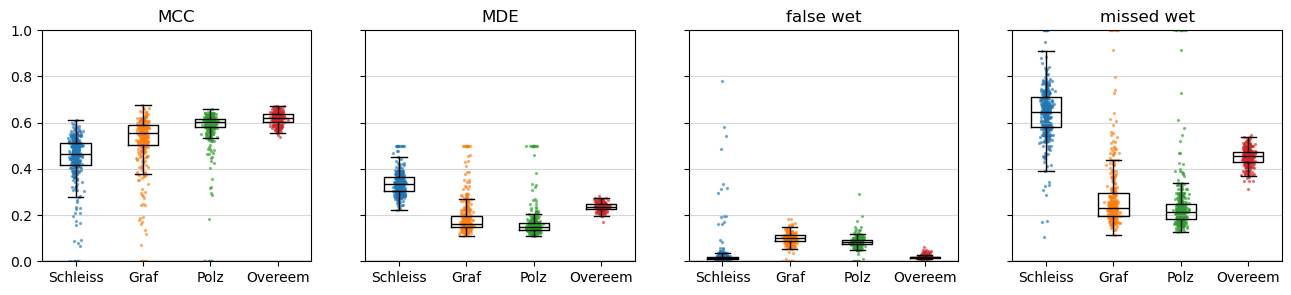

In [111]:
fig, ax = plt.subplots(1,4,figsize=(16,3),sharey=True)

for metric_list,metric,i in zip([mcc_list,mde_list,false_wet_list,missed_wet_list],['MCC','MDE','false wet','missed wet'],range(4)):
    plt.sca(ax[i])
    for i in range(4):
        x=np.random.normal(i+1, 0.04, size=len(metric_list[i]))
        plt.scatter(x,metric_list[i],s=2,alpha=0.5)
    plt.boxplot(metric_list,sym="", medianprops=dict(color='black') )
    plt.hlines(0,0.5,4.5,color='grey',alpha=0.25)
    plt.xticks([1,2,3,4],['Schleiss','Graf','Polz','Overeem'])
    plt.ylim(0,1)
    plt.title(metric)
    plt.grid(axis='y',alpha=0.5)